# Classification with hyperparameter tuning

The aim of this lab session is to show different strategies of *Classification tuning* and *evaluation* of the classifier.

The two main strategies are:
 1. **Holdout**
 1. **Cross validation** on training set, and then on test set

These two methods are both meant for increasing evaluation reliability. While method **2.** is more reliable, it also requires several repetitions. Therefore, if the learning method is expensive, it requires long processing time. If method **1.** gives higher accuracy, due to intrinsic variation caused by random sampling, it means that the forecast towards generalization is less reliable.

(N.B. **Generalization** is the capacity of an algorithm to generate a model - leveraging a dataset - that performs well on previously unseen data.
In the forecasting context, the data is unseen because the model predicts future events, which are unobservable.)

In [1]:
# First of all, as usual, import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

%matplotlib inline

In [2]:
# Import the dataset
df = pd.read_csv('winequality-red.csv', sep=';')    # Remember to look for the sep and specify it, if it is not a comma
target = 'quality'
 
# and print the shape
print(f'Shape of the input data: {df.shape}')

Shape of the input data: (1599, 12)


### Let's have a look at the data

In [3]:
# Show the first five rows
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

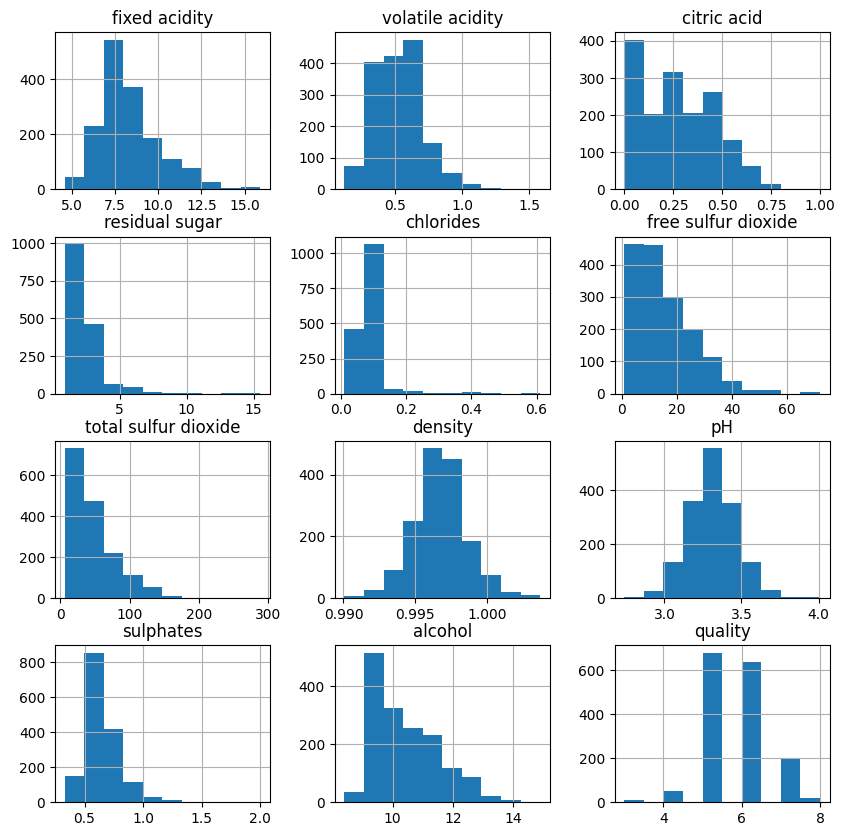

In [4]:
# Show an histogram of the columns
df.hist(figsize = (10,10));

In [5]:
# Show the class values
class_labels = df['quality'].unique()
class_labels_sorted = np.sort(class_labels)
print(class_labels_sorted)

[3 4 5 6 7 8]


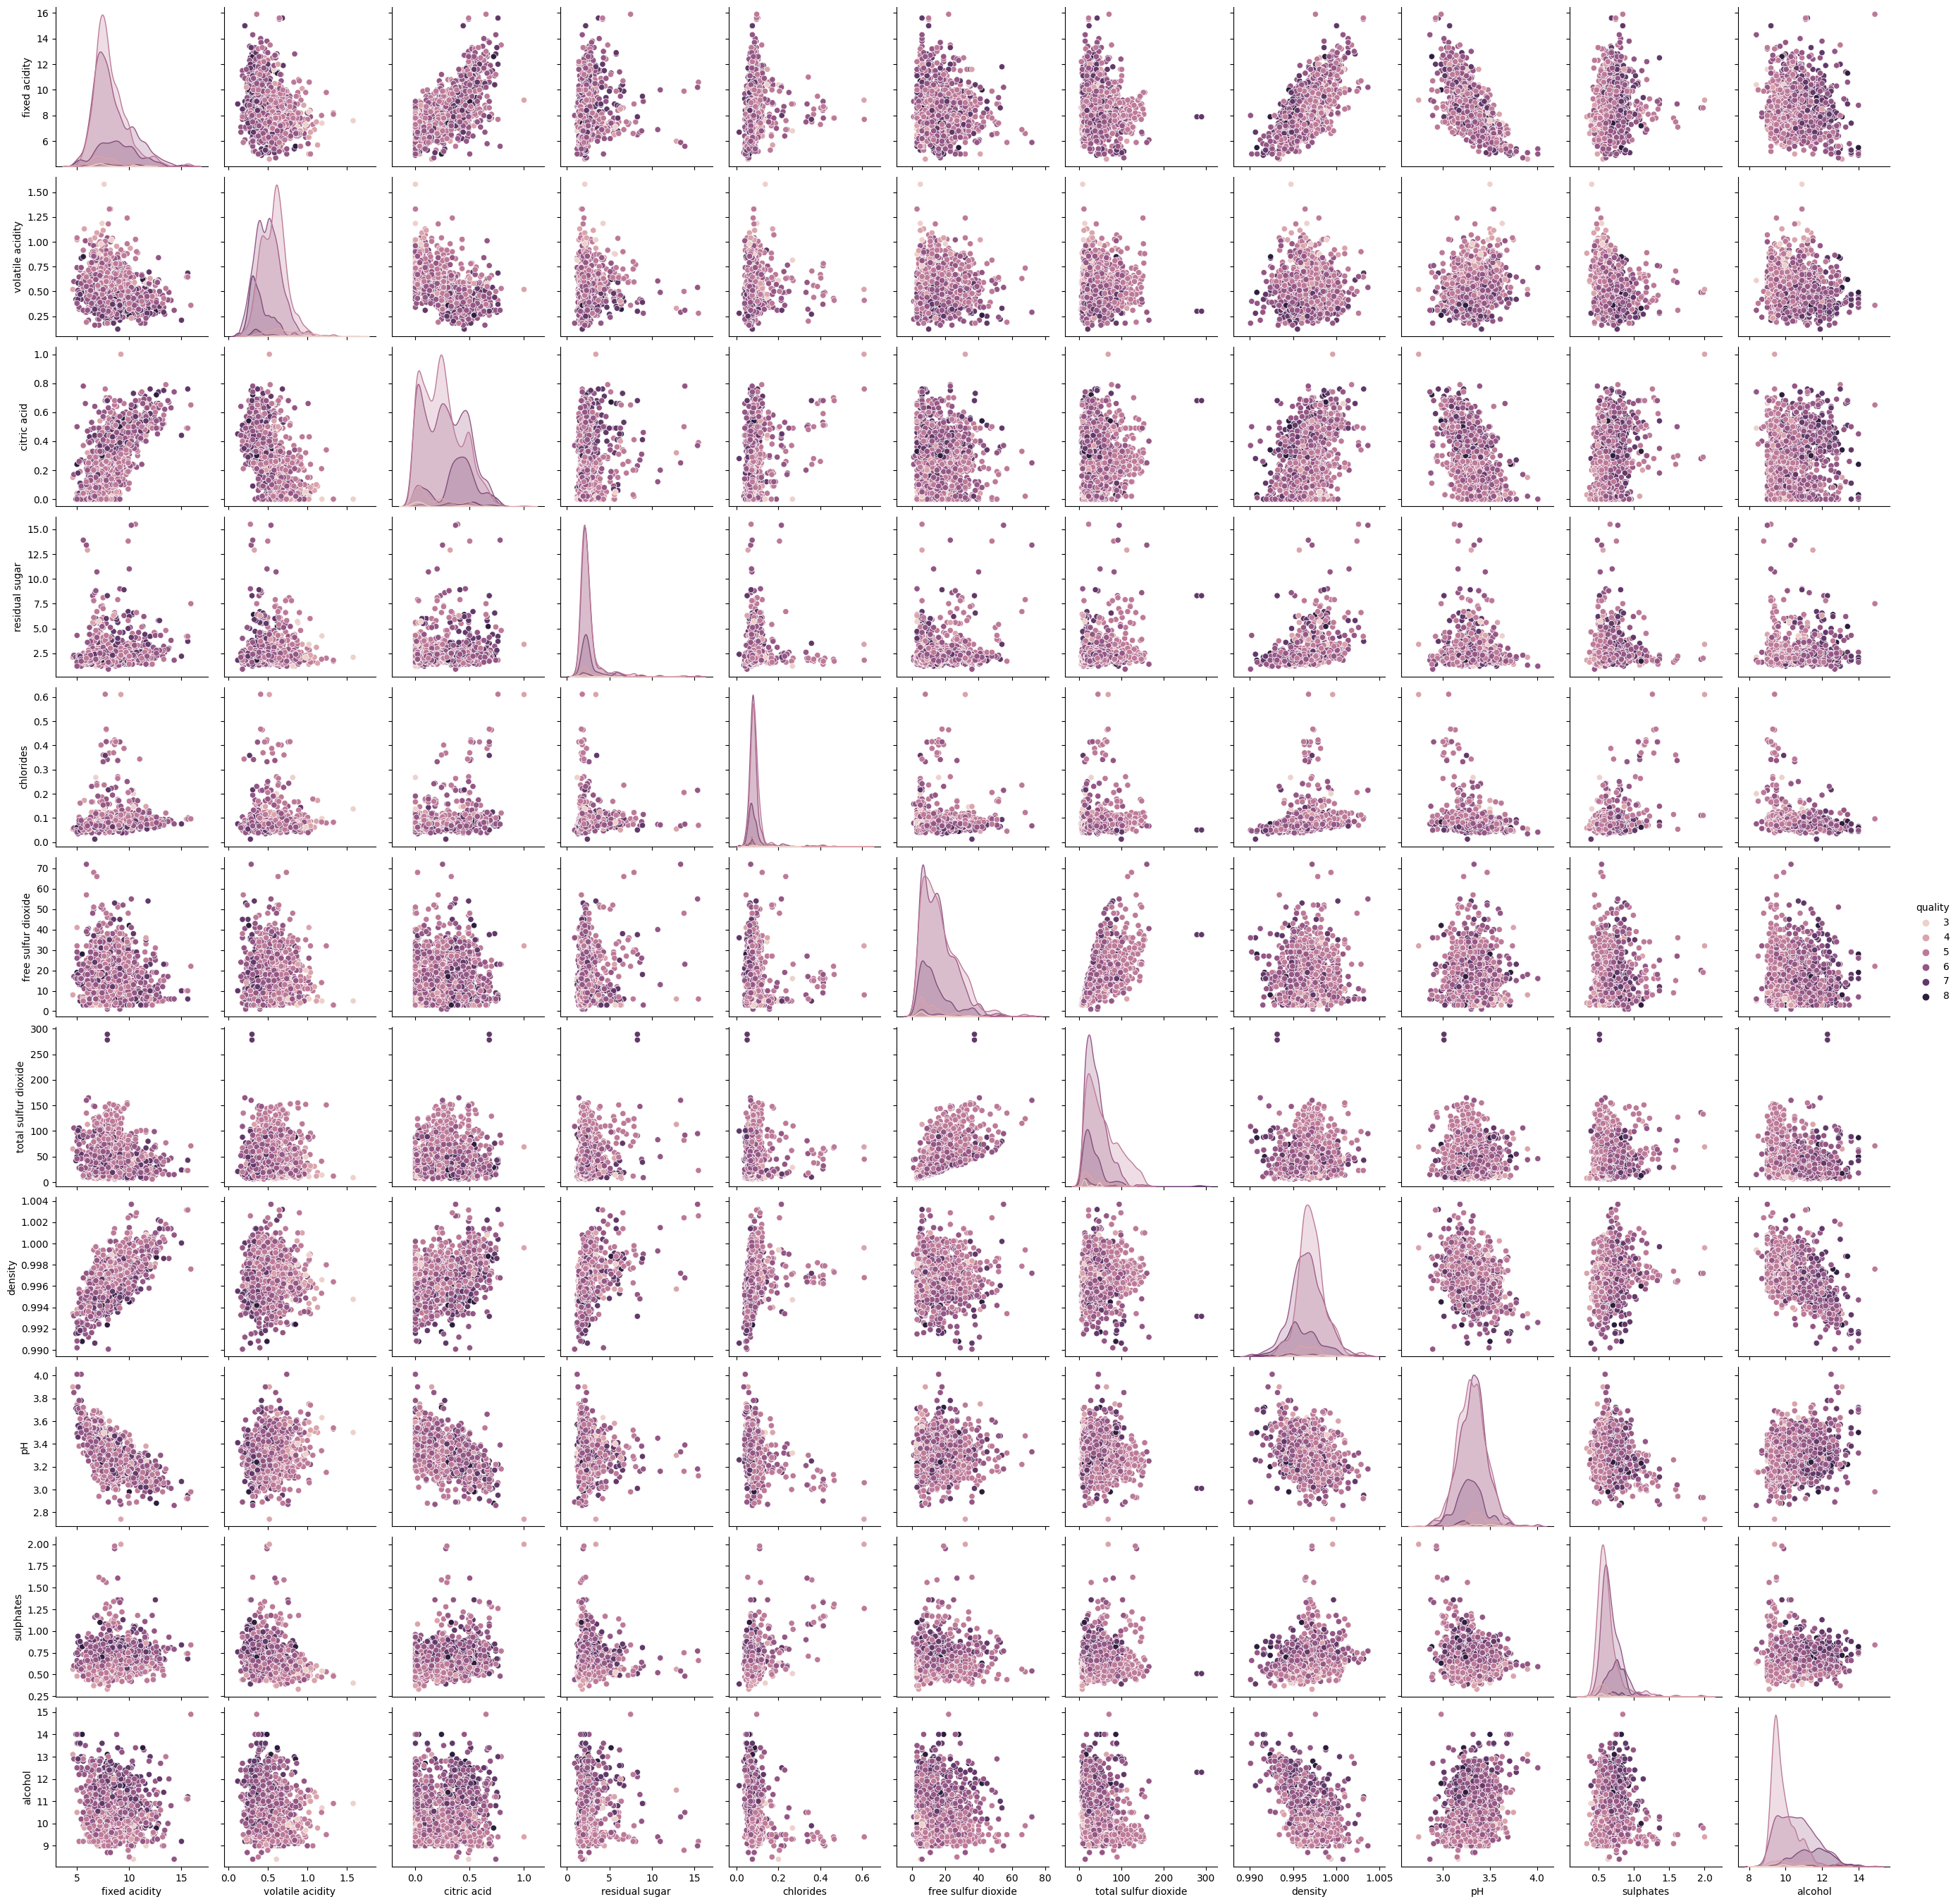

In [6]:
# Show the pairplots of the attributes, 
# using the target class as hue
sns.pairplot(df, hue = 'quality', diag_kind = 'kde', diag_kws={'bw_method':0.2});

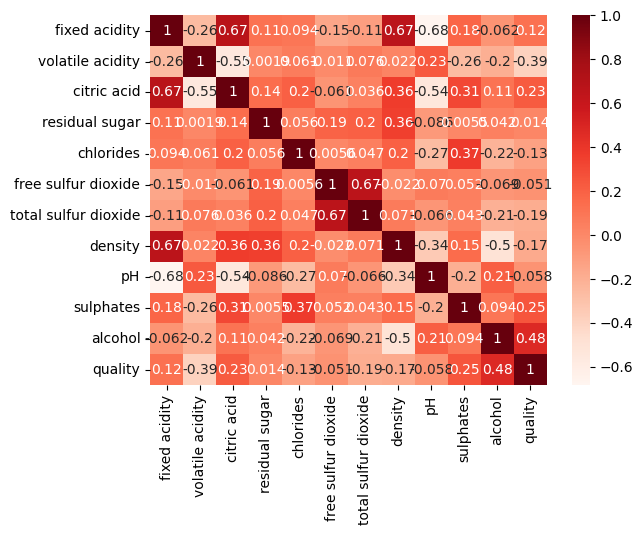

In [7]:
# And show correlation
corr = df[df.columns].corr()
sns.heatmap(corr, cmap = 'Reds', annot = True);

Now, let's split the data into the predicting values X and the class y

In [8]:
# First of all, drop the target column from the dataset
X = df.drop(['quality'], axis = 1)

# And define the class
y = df[target]

# Print the shape
print(X.shape)
print(y.shape)
print('')

# And print the first five rows 
print(X.head())
print('')
print(y.head())

(1599, 11)
(1599,)

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4

# Holdout method

In [9]:
# Split X and y in train and test
random_state = 15
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    train_size = 0.66,
                                                    random_state = random_state)

print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 1055 samples in the training dataset
There are 544 samples in the testing dataset
Each sample has 11 features


## Part 1 - *Single run* with default parameters

In [44]:
# Initialize an estimator
from sklearn.tree import DecisionTreeClassifier
estimator = DecisionTreeClassifier(criterion='entropy', random_state = random_state)

# Fit the estimator on the train data and target:
# Build a decision tree classifier from the training set (X_train, y_train).
estimator.fit(X_train, y_train);

Let's see how the estimator works on training data

In [45]:
from sklearn.metrics import accuracy_score

# Predict the target using the fitted estimator on the training data
y_pred_train = estimator.predict(X_train)

# And compute the accuracy on the training set
accuracy_train = accuracy_score(y_pred_train, y_train)*100
print("The accuracy on training set is {0:.1f}%".format(accuracy_train))

The accuracy on training set is 100.0%


Now, we want to knowhow it works on test data, and, then, compare it with the results obtained on training data and see if *overfitting* is present.

In [46]:
# Exploit the fitted estimator to predict the test features
y_pred_test = estimator.predict(X_test)

# And compute the accuracy on the test set
accuracy_ho = accuracy_score(y_pred_test, y_test)*100
print("The accuracy on test set is {0:.1f}%".format(accuracy_ho))

The accuracy on test set is 57.9%


In [47]:
# Store the maximum depth of the tree
max_depth_tree = estimator.tree_.max_depth

# Store the range of the parameter which will be used for tuning
parameter_values = range(1, max_depth_tree)

# Print the maximum depth of the tree
print(f'The maximum depth of the tree fitted on X_train is {max_depth_tree}')

The maximum depth of the tree fitted on X_train is 19


## Part 2 - Compute accuracy with **Cross Validation**

Optimization (*tuning*) of the hyperparameters with **cross validation**:
- tune the hp looping on cross validation with the **training set**
- fit the estimator on the training set and evaluate the performance on the **test set** 

In [29]:
from sklearn.model_selection import cross_val_score

scores_list = []
for par in parameter_values:
    estimator_cv = tree.DecisionTreeClassifier(criterion="entropy"
                                            , max_depth = par
                                            , random_state = random_state
                                            )
    scores = cross_val_score(estimator_cv, X_train, y_train
                             , scoring='accuracy', cv = 5)
    # cross_val_score produces an array with one score for each fold
    scores_list.append(np.mean(scores))
print(scores_list)

[0.5488151658767773, 0.5355450236966824, 0.5573459715639811, 0.5658767772511849, 0.5772511848341232, 0.5649289099526066, 0.5488151658767773, 0.584834123222749, 0.5658767772511848, 0.5668246445497631, 0.5838862559241706, 0.5725118483412323, 0.581042654028436, 0.5753554502369668, 0.576303317535545, 0.581042654028436, 0.5744075829383886, 0.576303317535545]


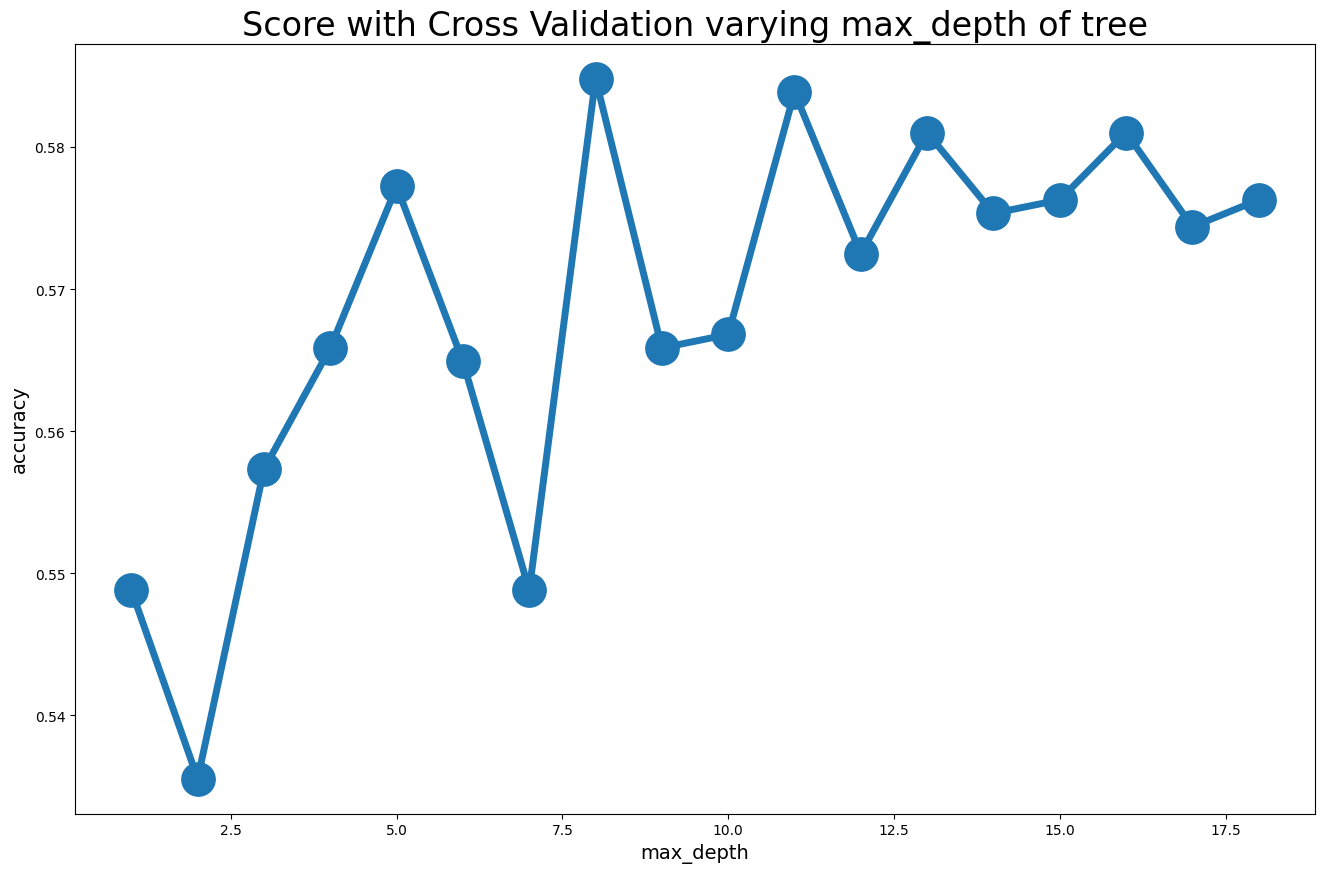

In [30]:
# Plot
plt.figure(figsize=(16,10))
plt.plot(parameter_values, scores_list, '-o', linewidth=5, markersize=24)
plt.xlabel('max_depth', fontsize = 14)
plt.ylabel('accuracy', fontsize = 14)
plt.title("Score with Cross Validation varying max_depth of tree", fontsize = 24)
plt.show();

Fit the tree after cv and print summary.

In [48]:
# Score the parameter values giving the best score
best_sc = parameter_values[np.argmax(scores_list)]

# Initialize another estimator as a DecisionTreeClassifier
estimator_cv_2 = DecisionTreeClassifier(criterion='entropy', max_depth = best_sc, random_state = random_state)

# Fit the estimator
estimator_cv_2.fit(X_train, y_train);

# Predict using the test features, exploiting the fitted estimator
y_pred_test_cv = estimator_cv_2.predict(X_test)

# Compute the accuracy on the test
accuracy_cv = accuracy_score(y_pred_test_cv, y_test)*100

print(f'The accuracy on the test set tuned with cross validation is {accuracy_cv:.1f}% and the best parameter value, i.e. the depth, is {best_sc}')


The accuracy on the test set tuned with cross validation is 55.7% and the best parameter value, i.e. the depth, is 8


A more detailed information is shown, using the true and the predicted target values.

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test_cv))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        18
           5       0.64      0.66      0.65       227
           6       0.54      0.57      0.55       223
           7       0.42      0.38      0.40        65
           8       0.00      0.00      0.00         6

    accuracy                           0.56       544
   macro avg       0.27      0.27      0.27       544
weighted avg       0.54      0.56      0.55       544



- **micro**:
Calculate metrics globally by counting the total true positives, false negatives and false positives.
- **macro**:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
- **weighted**:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

At last, let's print the confusion matrix. 

In [50]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_test_cv))

[[  0   0   5   0   0   0]
 [  0   0   8   9   1   0]
 [  0   7 150  64   6   0]
 [  1   2  67 128  23   2]
 [  0   0   3  36  25   1]
 [  0   0   0   2   4   0]]


## Final report

In [51]:
print("                                        Accuracy   Hyperparameter")
print("Simple HoldOut and full tree        :   {:.1f}%      {}"\
      .format(accuracy_ho, max_depth_tree))
print("CrossValidation and tuning          :   {:.1f}%      {}"\
      .format(accuracy_cv, best_sc))

                                        Accuracy   Hyperparameter
Simple HoldOut and full tree        :   57.9%      19
CrossValidation and tuning          :   55.7%      8
